In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/WLASL100.zip"
extract_path = "/content/WLASL100"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/WLASL100


In [3]:
import os

base_path = "/content/WLASL100"

for root, dirs, files in os.walk(base_path):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files[:5])  # only print first 5 files in each folder
    print("------")


Streaming output truncated to the last 5000 lines.
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/book/07072
Subdirectories: []
Files: ['book_12.jpg', 'book_14.jpg', 'book_1.jpg', 'book_5.jpg', 'book_10.jpg']
------
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/cook
Subdirectories: ['13154', '70030']
Files: ['13154.npy', '70030.npy']
------
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/cook/13154
Subdirectories: []
Files: ['cook_14.jpg', 'cook_7.jpg', 'cook_0.jpg', 'cook_8.jpg', 'cook_6.jpg']
------
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/cook/70030
Subdirectories: []
Files: ['cook_14.jpg', 'cook_7.jpg', 'cook_0.jpg', 'cook_8.jpg', 'cook_6.jpg']
------
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/kiss
Subdirectories: ['31750', '31758', '31749']
Files: ['31758.npy', '31750.npy', '31749.npy']
------
Directory: /content/WLASL100/WLASL100/preprocessing/test/pose/kiss/31750
Subdirectories: []
Files: ['kiss

In [4]:
import os

base_path = "/content/WLASL100"
print("Top-level folders/files:")
print(os.listdir(base_path))


Top-level folders/files:
['WLASL100']


In [5]:
import os
from glob import glob
from sklearn.model_selection import train_test_split

# Path to your dataset
DATASET_DIR = "/content/WLASL100/WLASL100/preprocessing/val/frames"

# Grab only a few classes for a quick test
selected_classes = ['fine', 'but', 'computer', 'letter', 'many']

# Get image paths and labels
image_paths = []
labels = []

for label in selected_classes:
    class_dir = os.path.join(DATASET_DIR, label)
    if os.path.exists(class_dir):
        for subdir in os.listdir(class_dir):
            frame_dir = os.path.join(class_dir, subdir)
            if os.path.isdir(frame_dir):
                for img_file in os.listdir(frame_dir):
                    if img_file.endswith('.jpg'):
                        image_paths.append(os.path.join(frame_dir, img_file))
                        labels.append(label)

print(f"Total images collected: {len(image_paths)}")
print(f"Sample image: {image_paths[0]}")
print(f"Corresponding label: {labels[0]}")


Total images collected: 288
Sample image: /content/WLASL100/WLASL100/preprocessing/val/frames/fine/21874/fine_10.jpg
Corresponding label: fine


In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

# Map text labels to numbers
label_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}

# Custom Dataset
class SignLanguageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_to_idx[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Create Dataset objects
train_dataset = SignLanguageDataset(X_train, y_train, transform=transform)
test_dataset = SignLanguageDataset(X_test, y_test, transform=transform)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 230, Test samples: 58


In [7]:
from torch.utils.data import DataLoader

# Set batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([16, 3, 128, 128]), Labels: tensor([2, 0, 2, 1, 3, 4, 2, 0, 2, 2, 3, 0, 1, 1, 1, 0])


In [9]:
import torch

# Use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = x.view(-1, 64 * 32 * 32)          # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate model
num_classes = len(label_to_idx)
model = SignLanguageCNN(num_classes).to(device)
print(model)


SignLanguageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [11]:
import torch.nn as nn
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()          # zero the parameter gradients
        outputs = model(images)        # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()                # backward pass
        optimizer.step()               # update weights

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/5, Loss: 1.9545
Epoch 2/5, Loss: 0.7788
Epoch 3/5, Loss: 0.2745
Epoch 4/5, Loss: 0.0895
Epoch 5/5, Loss: 0.0339


In [14]:
model.eval()  # switch to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 100.00%


In [15]:
# Save the model weights
torch.save(model.state_dict(), 'sign_language_cnn.pth')
print("Model saved as sign_language_cnn.pth")


Model saved as sign_language_cnn.pth


In [16]:
import torch
from torchvision import transforms
from PIL import Image

# Make sure the class SignLanguageCNN is defined (same as before)
# Also, have label_to_idx dictionary to map indices back to labels

# Load the saved model weights
num_classes = len(label_to_idx)
model = SignLanguageCNN(num_classes)
model.load_state_dict(torch.load('sign_language_cnn.pth'))
model.eval()  # Set to evaluation mode

# Define image transforms (same as training transforms)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Reverse map index to label
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    predicted_label = idx_to_label[predicted.item()]
    return predicted_label

# Example usage:
test_image_path = '/content/WLASL100/WLASL100/preprocessing/val/frames/fine/21874/fine_10.jpg'
prediction = predict_image(test_image_path)
print(f'Predicted sign: {prediction}')


Predicted sign: many


In [17]:
model.eval()  # Set model to evaluation mode

batch_images, batch_labels = next(iter(test_loader))  # Get one batch from test loader
batch_images = batch_images.to(device)

with torch.no_grad():
    outputs = model(batch_images)
    _, predicted = torch.max(outputs, 1)

# Convert indices back to labels
predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(idx)] for idx in predicted.cpu().numpy()]
true_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(idx)] for idx in batch_labels.numpy()]

# Print predicted and true labels
for i in range(len(predicted_labels)):
    print(f"Image {i+1}: Predicted - {predicted_labels[i]}, True - {true_labels[i]}")


Image 1: Predicted - many, True - many
Image 2: Predicted - fine, True - fine
Image 3: Predicted - letter, True - letter
Image 4: Predicted - letter, True - letter
Image 5: Predicted - many, True - many
Image 6: Predicted - computer, True - computer
Image 7: Predicted - letter, True - letter
Image 8: Predicted - computer, True - computer
Image 9: Predicted - fine, True - fine
Image 10: Predicted - letter, True - letter
Image 11: Predicted - but, True - but
Image 12: Predicted - computer, True - computer
Image 13: Predicted - fine, True - fine
Image 14: Predicted - computer, True - computer
Image 15: Predicted - but, True - but
Image 16: Predicted - computer, True - computer


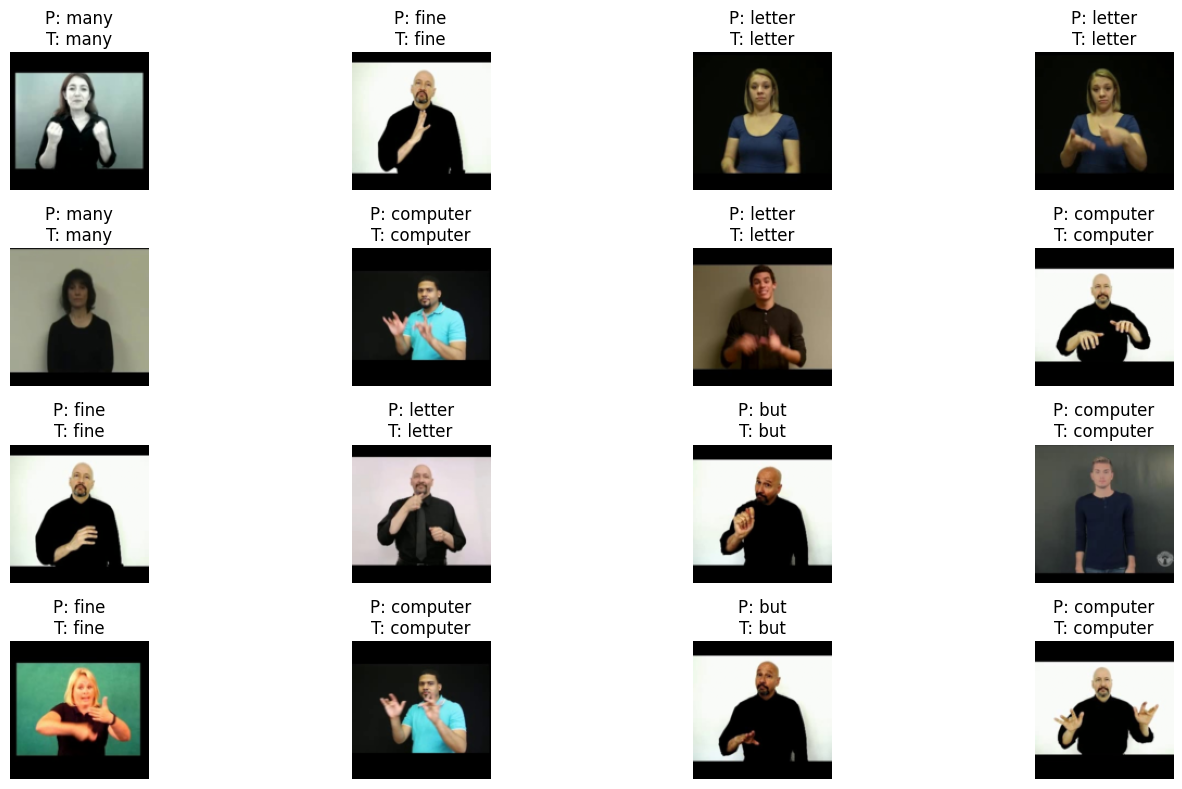

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and convert tensor to numpy image for plotting
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you normalized earlier
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

model.eval()
batch_images, batch_labels = next(iter(test_loader))
batch_images = batch_images.to(device)

with torch.no_grad():
    outputs = model(batch_images)
    _, predicted = torch.max(outputs, 1)

predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(idx)] for idx in predicted.cpu().numpy()]
true_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(idx)] for idx in batch_labels.numpy()]

# Show images with predicted and true labels
plt.figure(figsize=(15, 8))
for i in range(len(batch_images)):
    plt.subplot(4, 4, i+1)  # Adjust subplot grid size according to batch size (assumed 16 here)
    imshow(batch_images[i].cpu())
    plt.title(f"P: {predicted_labels[i]}\nT: {true_labels[i]}")
plt.tight_layout()
plt.show()
